[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


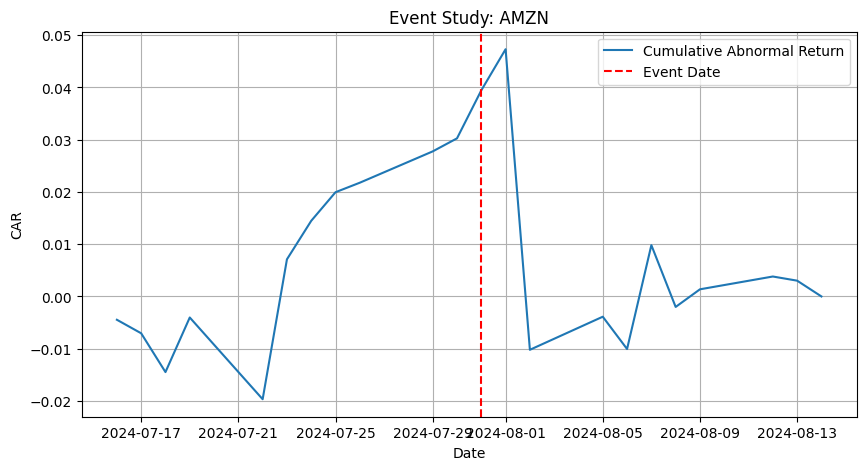

In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 수집
ticker = 'AMZN'
start_date = '2024-07-15'
end_date = '2024-08-15'
data = yf.download(ticker, start=start_date, end=end_date)

# 2. 수익률 계산
data['Return'] = data['Close'].pct_change()

# 3. 시장 수익률 계산 (예: S&P 500)
market_data = yf.download('^GSPC', start=start_date, end=end_date)
market_data['Market_Return'] = market_data['Close'].pct_change()

# 멀티컬럼을 단일 컬럼으로 변경
data.columns = data.columns.get_level_values(0)
market_data.columns = market_data.columns.get_level_values(0)

# 4. 데이터 병합
data = data.join(market_data['Market_Return'])

# 5. 회귀 분석을 통한 정상 수익률 추정
data = data.dropna()
import statsmodels.api as sm
X = sm.add_constant(data['Market_Return'])
model = sm.OLS(data['Return'], X).fit()
data['Normal_Return'] = model.predict(X)

# 6. 이상 수익률 계산
data['Abnormal_Return'] = data['Return'] - data['Normal_Return']

# 7. 누적 이상 수익률 계산
data['CAR'] = data['Abnormal_Return'].cumsum()

# 8. 결과 시각화
plt.figure(figsize=(10,5))
plt.plot(data.index, data['CAR'], label='Cumulative Abnormal Return')
plt.axvline(x=pd.to_datetime('2024-07-31'), color='red', linestyle='--', label='Event Date')
plt.title('Event Study: AMZN')
plt.xlabel('Date')
plt.ylabel('CAR')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
from statsmodels.api import OLS, add_constant
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp

# 1. 정상 수익률 예측 모델 적합 (이벤트 이전 20일 기준)
estimation_window = data.loc['2024-07-01':'2024-07-30']
X = add_constant(estimation_window['Market_Return'])
y = estimation_window['Return']
model = OLS(y, X).fit()

# 2. 이벤트 윈도우 설정 (-3일부터 +3일까지)
event_window = data.loc['2024-07-28':'2024-08-03']
X_event = add_constant(event_window['Market_Return'])

# 3. 정상 수익률 예측
event_window['Expected_Return'] = model.predict(X_event)

# 4. 이상 수익률 계산
event_window['Abnormal_Return'] = event_window['Return'] - event_window['Expected_Return']

# 5. 누적 이상 수익률
CAR = event_window['Abnormal_Return'].sum()

# 6. 통계적 검정 (t-test)
t_stat, p_value = ttest_1samp(event_window['Abnormal_Return'], 0)

print("누적 이상 수익률 (CAR):", CAR)
print("t-statistic:", t_stat)
print("p-value:", p_value)

누적 이상 수익률 (CAR): -0.0471050681766582
t-statistic: -0.6736767596052807
p-value: 0.5374402782947928


<ipython-input-13-40fa707ea726>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_window['Expected_Return'] = model.predict(X_event)
<ipython-input-13-40fa707ea726>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_window['Abnormal_Return'] = event_window['Return'] - event_window['Expected_Return']
